In [103]:
import pandas as pd
import numpy as np
import keras.layers.core as core
import keras.layers.convolutional as conv
import keras.models as models
import keras.utils.np_utils as kutils
import theano
from keras import backend as K
from nolearn.lasagne import visualize
import matplotlib.pyplot as plt

# Load the training and testing data
train = pd.read_csv("train.csv").values
test  = pd.read_csv("test.csv").values

# Number of epochs
nb_epoch = 5

# Batch size
batch_size = 128

# Define a 4D Tensor containing training data
trainX = train[:, 1:].reshape(train.shape[0], 1, img_height, img_width)
trainX = trainX.astype(float)

# Convert values from (0, 255) range to (0, 1) range
trainX /= 255.0

# Define a 4D Tensor containing training labels
trainY = kutils.to_categorical(train[:, 0])

# Number of classes
nb_classes = trainY.shape[1]

# Setting convolutional dimensions as (depth, input_depth, rows, cols)
K.set_image_dim_ordering('th')

# Defining a sequential model
cnn = models.Sequential()

# Adding Convolutional layer with 8 filters with size 5x5
cnn.add(conv.Convolution2D(8, 5, 5, border_mode='valid', input_shape=(1, 28, 28)))

# Applying ReLU activation
convout1 = core.Activation('relu')
cnn.add(convout1)

# Adding Convolutional layer with 16 filters with size 5x5
cnn.add(conv.Convolution2D(16, 5, 5, border_mode='valid'))

# Applying ReLU activation
convout2 = core.Activation('relu')
cnn.add(convout2)

# Adding MaxPooling layer
cnn.add(conv.MaxPooling2D(pool_size=(2, 2), strides=(2,2), border_mode='valid'))

# Vectorizing the output of the previous layer
cnn.add(core.Flatten())

# Dropout fraction = 0.3
cnn.add(core.Dropout(0.3))

# Fully-connected layer with ReLU activation
cnn.add(core.Dense(1280, activation="relu"))

# Dropout fraction = 0.3
cnn.add(core.Dropout(0.3))

# Fully-connected layer with ReLU activation
cnn.add(core.Dense(128, activation="relu"))

# Fully-connected layer with Softmax activation
cnn.add(core.Dense(nb_classes, activation="softmax"))

# Prints model summary
cnn.summary()

# Choosing Cross-Entropy Loss and Adadelta optimization
cnn.compile(loss="categorical_crossentropy", optimizer="adadelta", metrics=["accuracy"])

# Training the model for 5 epochs with batch size 128
cnn.fit(trainX, trainY, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)

# Setting up the test data
testX = test.reshape(test.shape[0], 1, 28, 28)
testX = testX.astype(float)
testX /= 255.0

# Getting predictions for test data from the trained model
yPred = cnn.predict_classes(testX)
np.savetxt('mnist-vggnet.csv', np.c_[range(1,len(yPred)+1),yPred], delimiter=',', header = 'ImageId,Label', comments = '', fmt='%d')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_67 (Convolution2D) (None, 8, 24, 24)     208         convolution2d_input_32[0][0]     
____________________________________________________________________________________________________
activation_7 (Activation)        (None, 8, 24, 24)     0           convolution2d_67[0][0]           
____________________________________________________________________________________________________
convolution2d_68 (Convolution2D) (None, 16, 20, 20)    3216        activation_7[0][0]               
____________________________________________________________________________________________________
activation_8 (Activation)        (None, 16, 20, 20)    0           convolution2d_68[0][0]           
___________________________________________________________________________________________

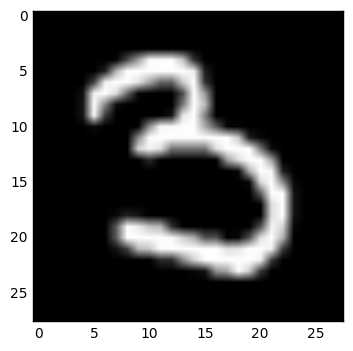

In [104]:
# Taking sample image with index '16' from the testset and displaying it
%matplotlib inline
arr = np.asarray(testX[16][0])
plt.imshow(arr, cmap='Greys_r')
plt.show()

<module 'matplotlib.pyplot' from '/home/pritish/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

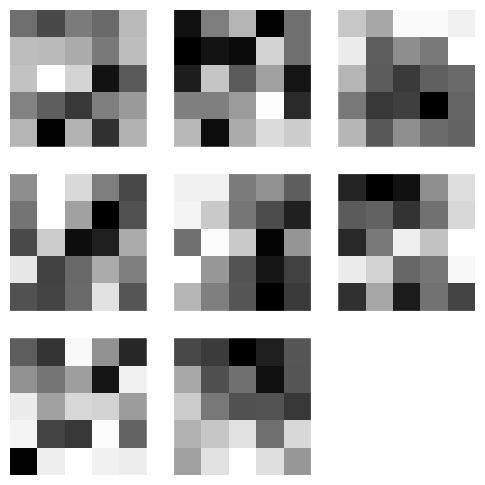

In [105]:
# Weights of first convolutional layer
weights1 = cnn.layers[0].get_weights() # 2x8x1x5x5 output, 1st dimension '2' corresponds to weights (index 0) and biases (index 1) 
%matplotlib inline
visualize.plot_conv_weights(cnn.layers[0])

<module 'matplotlib.pyplot' from '/home/pritish/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

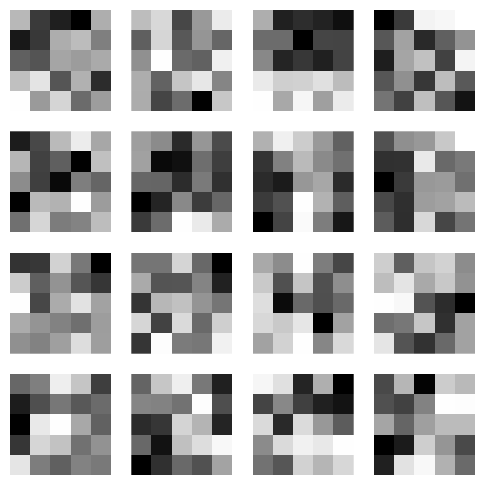

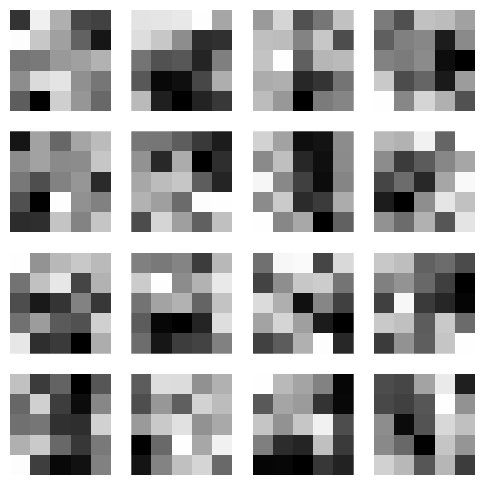

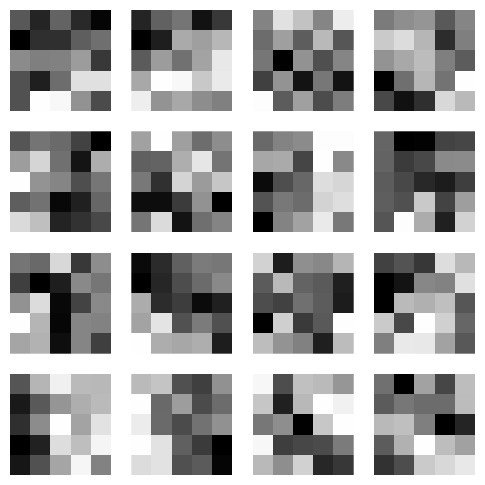

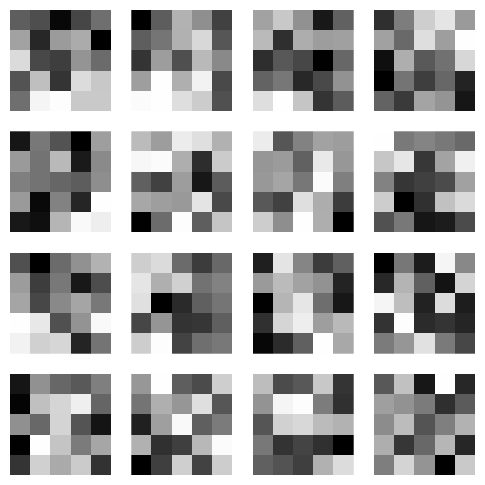

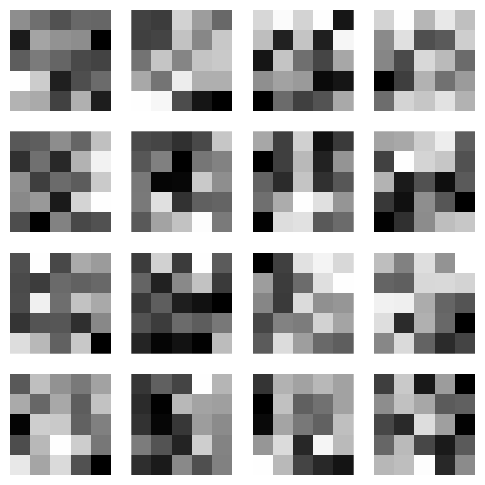

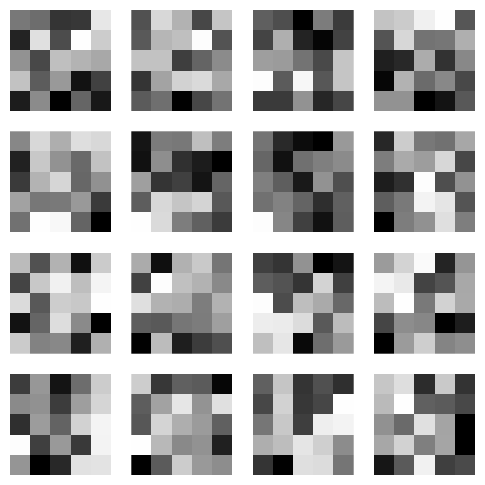

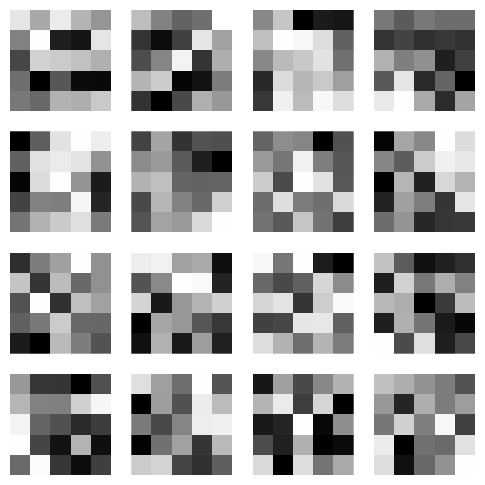

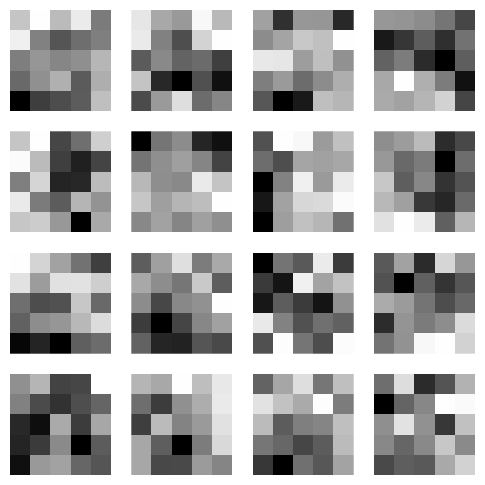

In [106]:
# Weights of second convolutional layer
weights2 = cnn.layers[2].get_weights() # 2x16x8x5x5 output
%matplotlib inline
visualize.plot_conv_weights(cnn.layers[2])

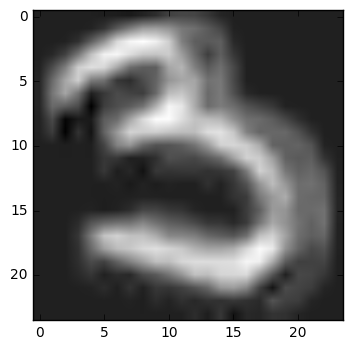

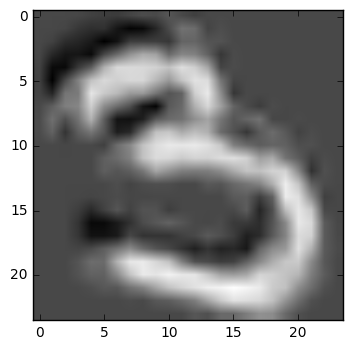

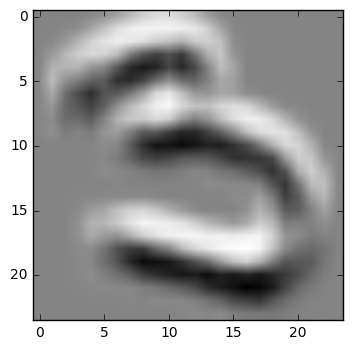

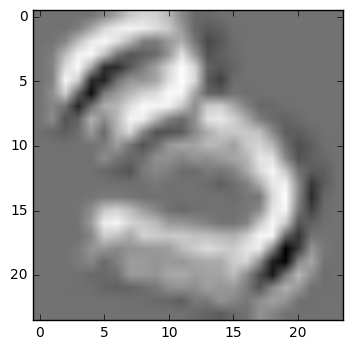

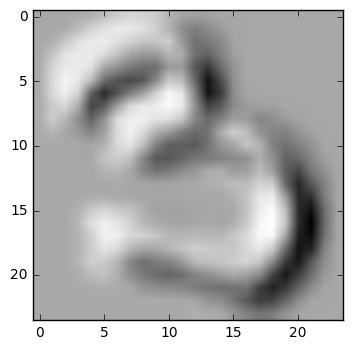

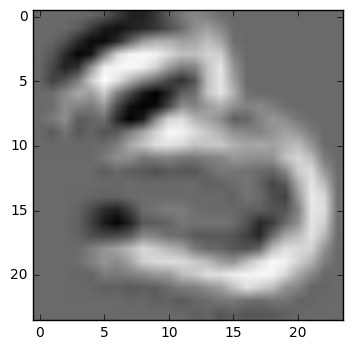

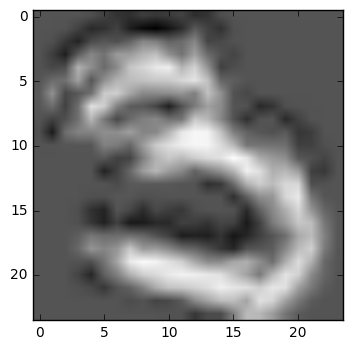

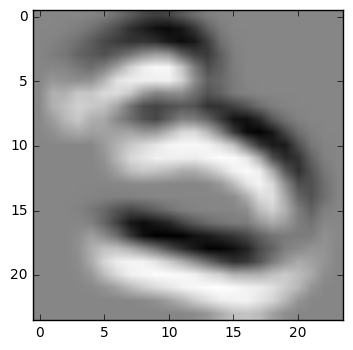

In [107]:
# Activations of first convolutional layer
get_activations1 = K.function([cnn.layers[0].input, K.learning_phase()], cnn.layers[0].output)
activations1 = get_activations1([testX, 0]) # shape 28000x8x24x24
%matplotlib inline
for i in range(0, 8):
    plt.imshow(activations1[16][i], cmap='Greys_r') # 16th image
    plt.show()

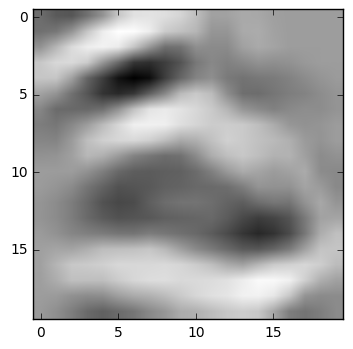

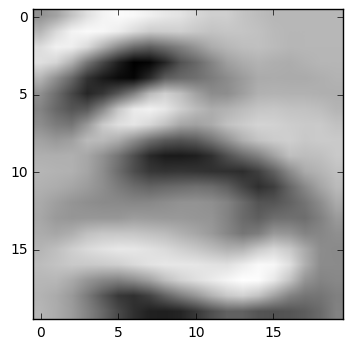

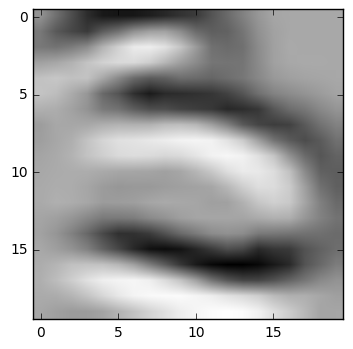

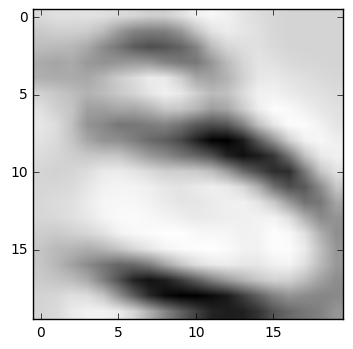

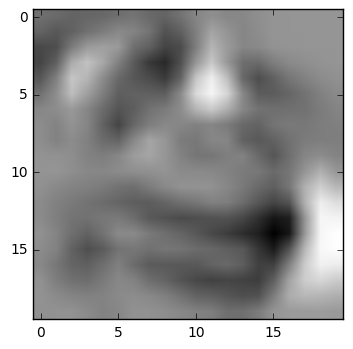

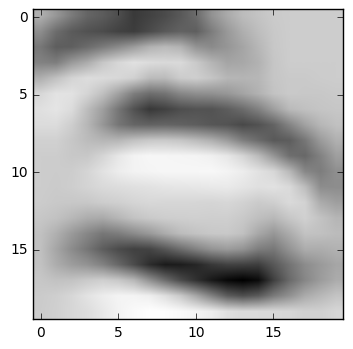

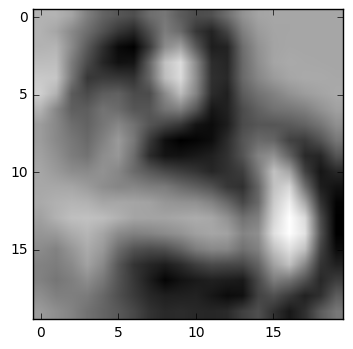

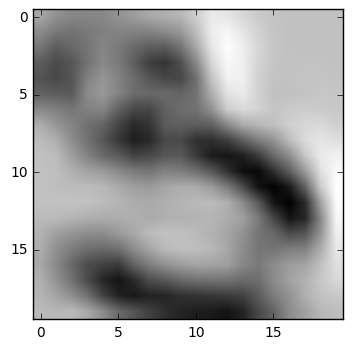

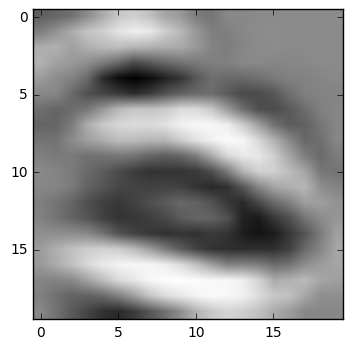

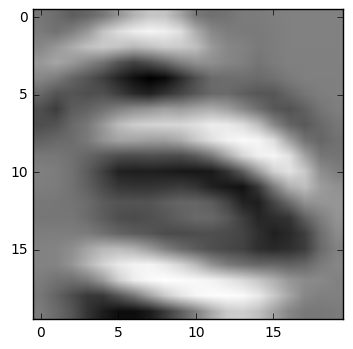

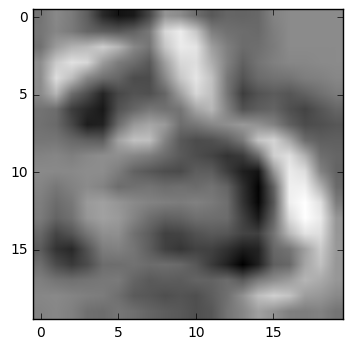

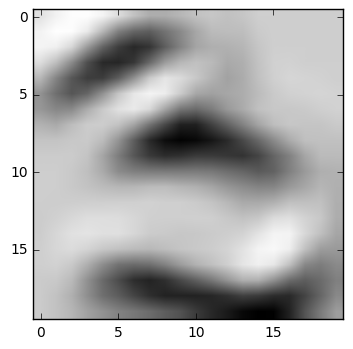

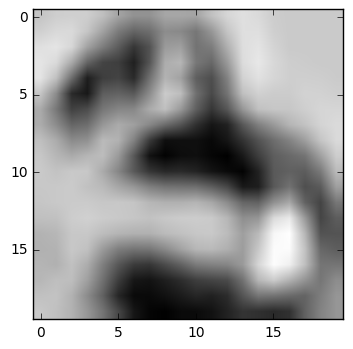

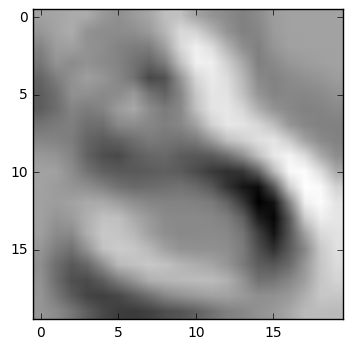

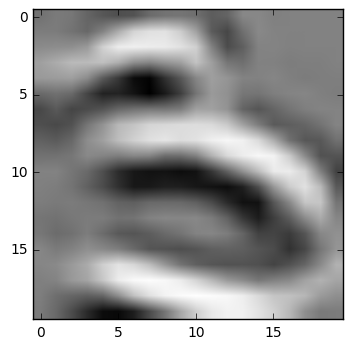

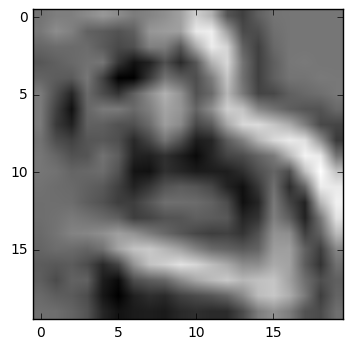

In [108]:
# Activations of second convolutional layer   
get_activations2 = K.function([cnn.layers[0].input, K.learning_phase()], cnn.layers[2].output)
activations2 = get_activations2([testX, 0]) # shape 28000x16x20x20
%matplotlib inline
for i in range(0, 16):
    plt.imshow(activations2[16][i], cmap='Greys_r') # 16th image
    plt.show()


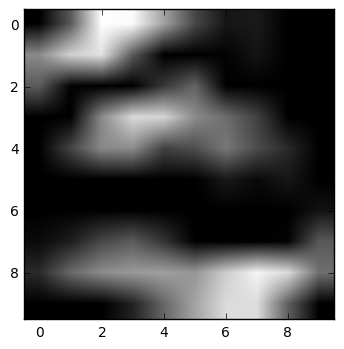

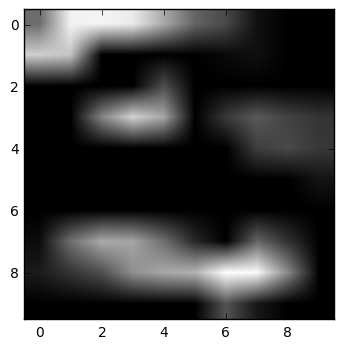

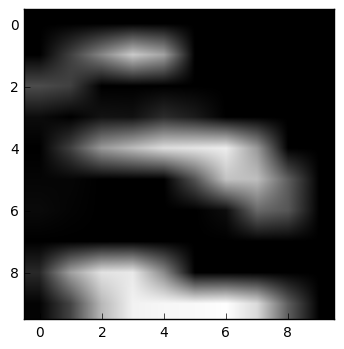

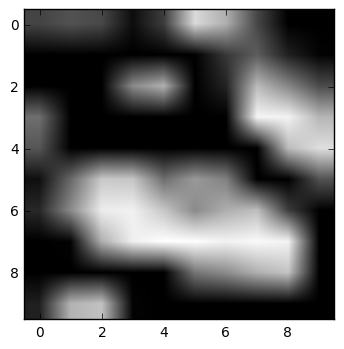

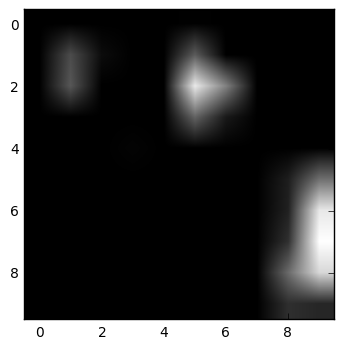

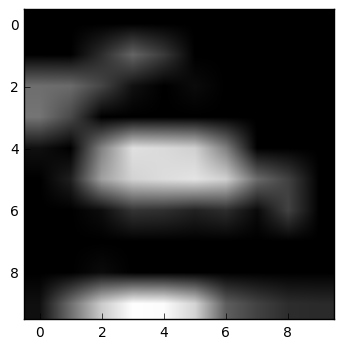

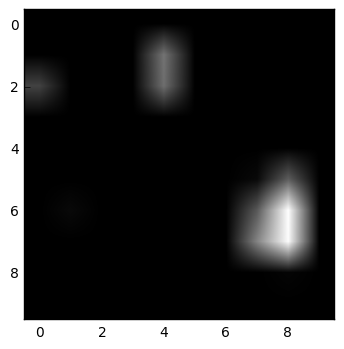

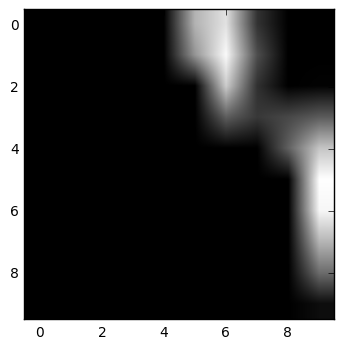

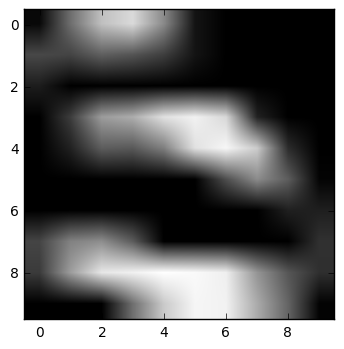

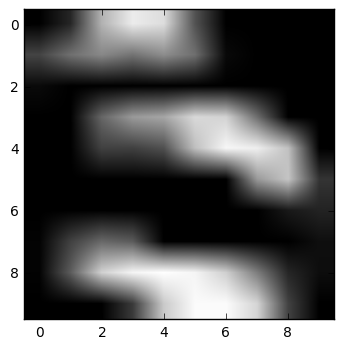

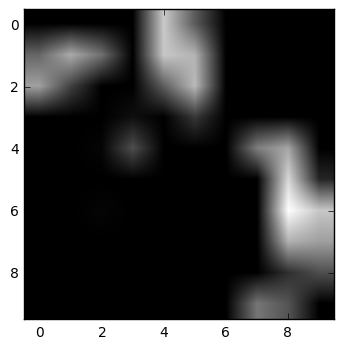

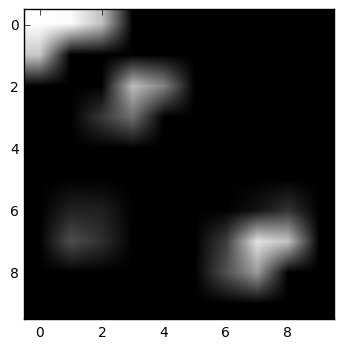

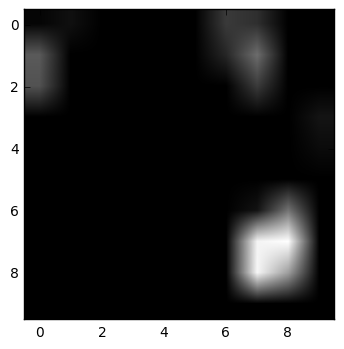

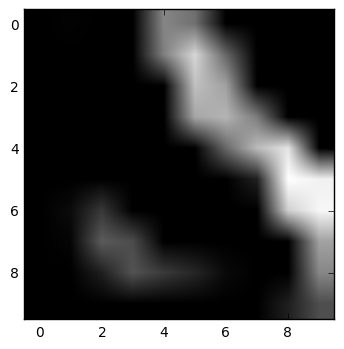

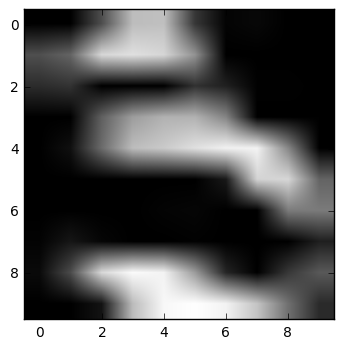

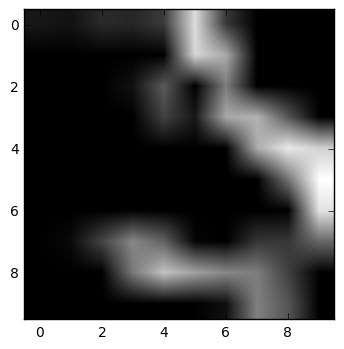

In [109]:
# Output of MaxPooling layer
get_maxpoolop = K.function([cnn.layers[0].input, K.learning_phase()], cnn.layers[4].output)
maxpoolop = get_maxpoolop([testX, 0]) # shape 28000x16x10x10
%matplotlib inline
for i in range(0, 16):
    plt.imshow(maxpoolop[16][i], cmap='Greys_r')    
    plt.show()